In [45]:
import numpy as np
import torch.nn as nn
import torch
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from itertools import product
from sklearn.metrics import r2_score

In [46]:
# Load the MB Model

class CustomModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Sequential(
            nn.Linear(5,80),
            nn.ReLU(),
            nn.Linear(80,80),
            nn.ReLU(),
            nn.Linear(80,80),
            nn.ReLU(),
            nn.Linear(80,80),
            nn.ReLU(),
            nn.Linear(80,80),
            nn.ReLU(),
            nn.Linear(80,2)
        )

    def forward(self, x):
        return self.hidden(x)
model = CustomModel()
model.load_state_dict(torch.load('model.pth'))

C:\Users\USER\AppData\Local\Temp\ipykernel_9644\1472994656.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model.pth'))


<All keys matched successfully>

In [47]:
# Load the surrogate model
with open('GPR1.pkl', 'rb') as f:
    GPR1 = pickle.load(f)

with open('GPR2.pkl', 'rb') as f:
    GPR2 = pickle.load(f)

In [48]:
# Load the Data
raw_Data= pd.read_excel('v4_BMED_data.xlsx',sheet_name="Opt2")
display(raw_Data[:5])

,T,V,E,Ci,t2,CF,CA,SEC,JLA
0,35.4,35,0.50,3.247751,2.000000,2.666598,0.272588,9.960608,223.608106
1,22.7,30,0.25,2.223349,0.500000,3.363995,0.001075,7.558347,22.050678
2,31.8,35,0.50,3.247751,2.933333,2.470914,0.577139,7.339164,543.993190
3,22.3,30,0.25,2.622149,3.000000,1.787875,0.097067,7.239258,47.522121
4,19.1,30,0.25,0.978717,3.000000,0.866674,0.007030,6.429151,6.259306


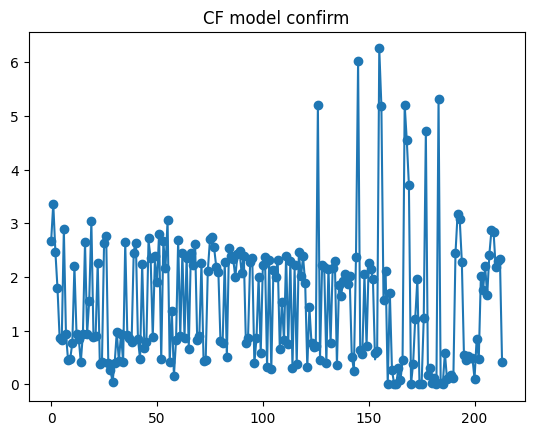

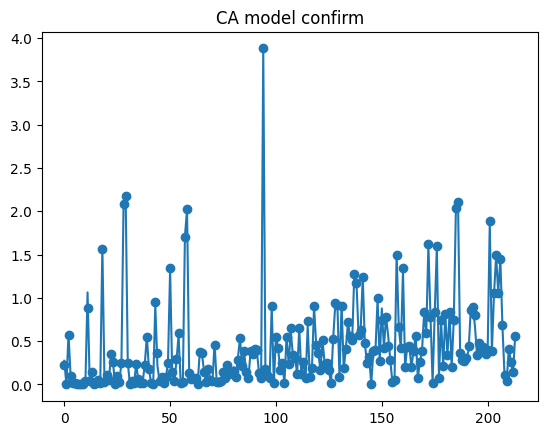

In [49]:
# MB model confirmation
df_MB_columns = ['T','V','E','Ci','t2','CF','CA']
df_MB = raw_Data[df_MB_columns]

# Data Set
Xm = df_MB[['T','V','E','Ci','t2']].values
Xt = torch.FloatTensor(Xm)

CF_p = [i[0] for i in model(Xt).detach().numpy()]
CA_p = [i[1] for i in model(Xt).detach().numpy()]
CF = df_MB[['CF']].values
CA = df_MB[['CA']].values

plt.plot(list(range(len(Xm))),CF)
plt.scatter(list(range(len(Xm))),CF_p)
plt.title('CF model confirm')
plt.show()

plt.plot(list(range(len(Xm))),CA)
plt.scatter(list(range(len(Xm))),CA_p)
plt.title('CA model confirm')
plt.show()

In [50]:
# GP model confirmation
df_GP_columns = ['T','V','E','Ci','t2','CF','CA','SEC','JLA']
df_GP = raw_Data[df_GP_columns]

# Data Set
Xg = df_GP[['T','V','E','Ci','t2','CF','CA']].values
Yg = df_GP[['SEC','JLA']].values

T, V, E, Ci, t2, CF, CA = [i[0] for i in Xg], [i[1] for i in Xg], [i[2] for i in Xg], [i[3] for i in Xg], [i[4] for i in Xg], [i[5] for i in Xg], [i[6] for i in Xg]
SEC, JLA = [i[0] for i in Yg], [i[1] for i in Yg]

# min-max normalization
mXg = list(range(len(Xg)))
mYg = list(range(len(Yg)))

for i in range(len(mXg)):
    iX = [(T[i]-np.min(T))/(np.max(T)-np.min(T)),(V[i]-np.min(V))/(np.max(V)-np.min(V)),(E[i]-np.min(E))/(np.max(E)-np.min(E)),(Ci[i]-np.min(Ci))/(np.max(Ci)-np.min(Ci)),(t2[i]-np.min(t2))/(np.max(t2)-np.min(t2)),(CF[i]-np.min(CF))/(np.max(CF)-np.min(CF)),(CA[i]-np.min(CA))/(np.max(CA)-np.min(CA))]
    iY = [(SEC[i]-np.min(SEC))/(np.max(SEC)-np.min(SEC)),(JLA[i]-np.min(JLA))/(np.max(JLA)-np.min(JLA))]
    mXg[i], mYg[i] = iX, iY
mX, mY = np.asarray(mXg), np.log(np.asarray(mYg)+0.1)

In [51]:
dSEC_log, dJLA_log = GPR1.predict(mX), GPR2.predict(mX)

mSEC = np.exp(dSEC_log)-0.1
mJLA = np.exp(dJLA_log)-0.1

SECp = list(range(len(Xg)))
JLAp = list(range(len(Xg)))
for i in range(len(Xg)):
    iSEC = (np.max(SEC) - np.min(SEC))*mSEC[i] + np.min(SEC)
    iJLA = (np.max(JLA) - np.min(JLA))*mJLA[i] + np.min(JLA)
    SECp[i] = iSEC
    JLAp[i] = iJLA



In [52]:
y_SEC = [i[0] for i in mYg]
y_JLA = [i[1] for i in mYg]
Y_SEC = mSEC
Y_JLA = mJLA

0.20366679963422563

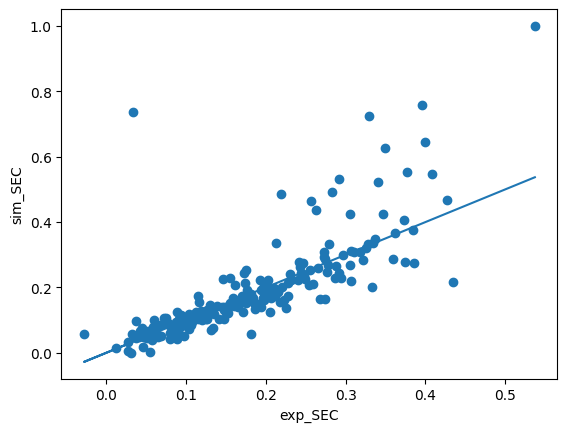

In [53]:
plt.scatter(Y_SEC,y_SEC)
plt.plot(Y_SEC,Y_SEC)
plt.xlabel('exp_SEC')
plt.ylabel('sim_SEC')
r2_score(Y_SEC,y_SEC)

0.9184307664614547

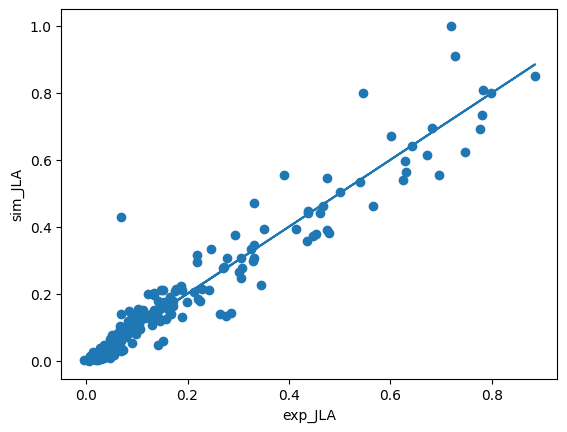

In [54]:
plt.scatter(Y_JLA,y_JLA)
plt.plot(Y_JLA,Y_JLA)
plt.xlabel('exp_JLA')
plt.ylabel('sim_JLA')
r2_score(Y_JLA,y_JLA)

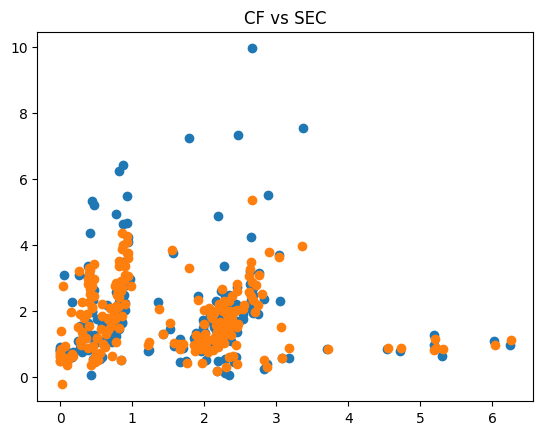

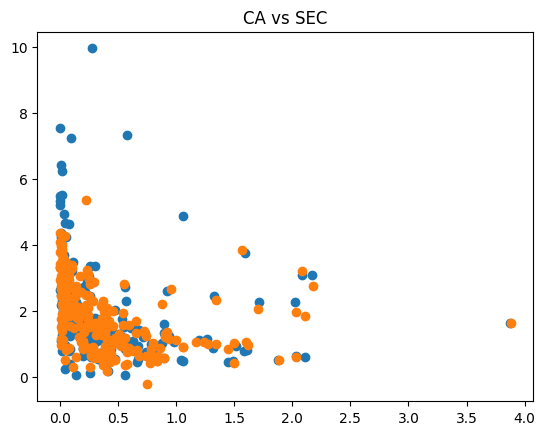

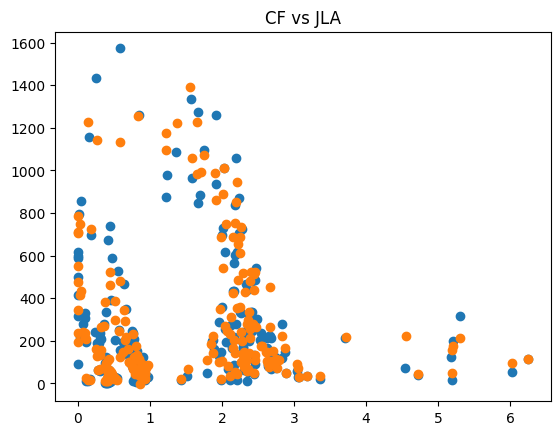

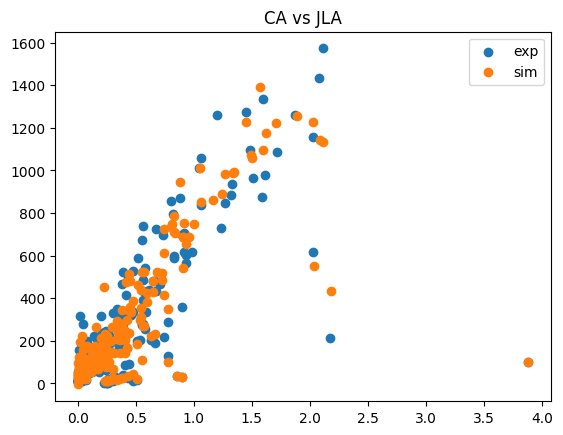

In [55]:
plt.scatter(raw_Data['CF'],raw_Data['SEC'])
plt.scatter(CF_p,SECp)
plt.title('CF vs SEC')
plt.show()
plt.scatter(raw_Data['CA'],raw_Data['SEC'])
plt.scatter(CA_p,SECp)
plt.title('CA vs SEC')
plt.show()
plt.scatter(raw_Data['CF'],raw_Data['JLA'])
plt.scatter(CF_p,JLAp)
plt.title('CF vs JLA')
plt.show()
plt.scatter(raw_Data['CA'],raw_Data['JLA'],label='exp')
plt.scatter(CA_p,JLAp,label='sim')
plt.title('CA vs JLA')
plt.legend()
plt.show()

In [56]:
# nT = np.unique(raw_Data['T'].values)
# nV = np.unique(raw_Data['V'].values)
# nE = np.unique(raw_Data['E'].values)
# nC = np.unique(raw_Data['Ci'].values)
# nt = np.unique(raw_Data['t'].values)
nT = np.linspace(25,36,5)
nV = np.linspace(10,36,5)
nE = np.linspace(0.25,1.25,5)
nC = np.linspace(0.4,6.5,10)
nt = np.linspace(1,30,30)
print('nC done')
input = np.array(list(product(nT,nV,nE,nC,nt)))
print('input done')
# Xm = df_MB[['T','V','E','Ci','t']].values
# input = np.array(Xm)
in_t = torch.FloatTensor(input)
print('in_t Done')
CFp = model_CF(in_t).detach().numpy()
print('CFP done')
CAp = model_CA(in_t).detach().numpy()
print('CAP done')

Cip = [i[3] for i in input]

# min-max normalization
mXg = list(range(len(input)))

for i in range(len(mXg)):
    iX = [(Cip[i]-np.min(Ci))/(np.max(Ci)-np.min(Ci)),(CFp[i][0]-np.min(CF))/(np.max(CF)-np.min(CF)),(CAp[i][0]-np.min(CA))/(np.max(CA)-np.min(CA))]
    mXg[i] = iX
    if i%100 ==0:
        print(f'Iteration: {i}/{len(input)}')
mX = np.asarray(mXg)

nC done
input done
in_t Done


NameError: name 'model_CF' is not defined

In [228]:
dSEC_log = GPR1.predict(mX)
dJLA_log = GPR2.predict(mX)

mSEC = np.exp(dSEC_log)-1e-10
mJLA = np.exp(dJLA_log)-1e-10



SECp = list(range(len(mSEC)))
JLAp = list(range(len(mSEC)))
for i in range(len(mSEC)):
    iSEC = (np.max(SEC) - np.min(SEC))*mSEC[i] + np.min(SEC)
    iJLA = (np.max(JLA) - np.min(JLA))*mJLA[i] + np.min(JLA)
    SECp[i] = iSEC
    JLAp[i] = iJLA

In [222]:
columns = ['T','V','E','Ci','t']
df = pd.DataFrame(input, columns= columns)
df['CF'] = CFp
df['CA'] = CAp
df['SECp'] = SECp
df['JLAp'] = JLAp
display(df)

df.to_excel('CFCA.xlsx', index = False)

,T,V,E,Ci,t,CF,CA,SECp,JLAp
0,25.0,10.0,0.25,0.418555,1.000000,0.400511,0.001619,18.996720,2.858120
1,25.0,10.0,0.25,0.418555,1.783333,0.386922,0.004898,18.477947,2.929859
2,25.0,10.0,0.25,0.418555,2.000000,0.383245,0.006216,18.276200,2.957629
3,25.0,10.0,0.25,0.418555,2.783333,0.370242,0.012762,17.317333,3.095502
4,25.0,10.0,0.25,0.418555,2.933333,0.367803,0.014364,17.092441,3.129795
...,...,...,...,...,...,...,...,...,...
10795,35.0,35.0,1.00,6.328111,22.500000,0.000016,0.892268,3.298018,10.368685
10796,35.0,35.0,1.00,6.328111,23.000000,0.000012,0.733339,3.931640,8.484358
10797,35.0,35.0,1.00,6.328111,23.466667,0.000009,0.593296,4.808299,6.873396
10798,35.0,35.0,1.00,6.328111,24.000000,0.000006,0.445625,6.311290,5.342148


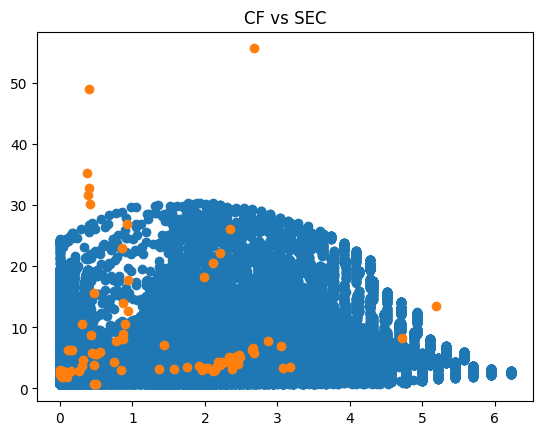

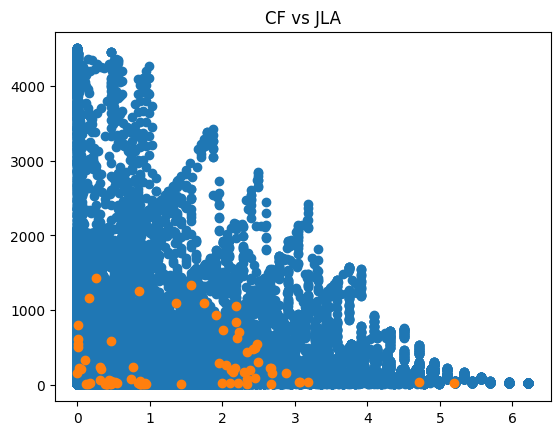

In [229]:
plt.scatter(CFp,SECp)
plt.scatter(raw_Data['CF'],raw_Data['SEC'])
plt.title('CF vs SEC')
plt.show()
plt.scatter(CFp,JLAp)
plt.scatter(raw_Data['CF'],raw_Data['JLA'])
plt.title('CF vs JLA')
plt.show()



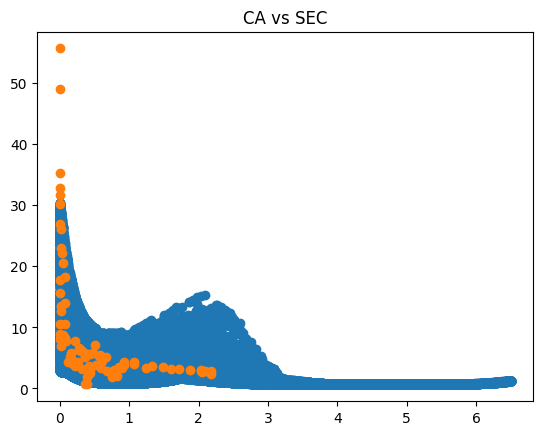

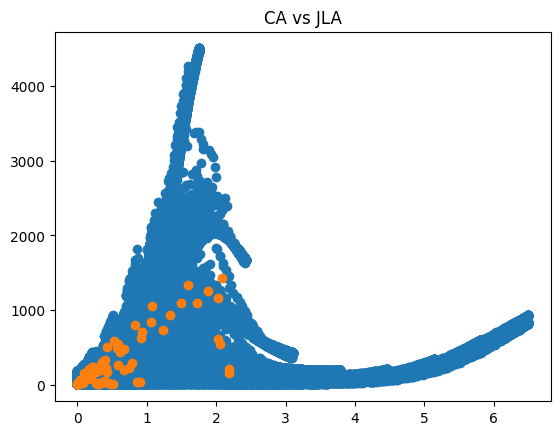

In [230]:
plt.scatter(CAp,SECp)
plt.scatter(raw_Data['CA'],raw_Data['SEC'])
plt.title('CA vs SEC')
plt.show()
plt.scatter(CAp,JLAp)
plt.scatter(raw_Data['CA'],raw_Data['JLA'])
plt.title('CA vs JLA')
plt.show()